In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform

In [ ]:
def pl(xx, steps):
    fig, axs = plt.subplots(1, 3, figsize=(15,3))
    xsigma = np.array(xx['sigma'])
    xs1 = xsigma[:,0]
    xs2 = xsigma[:,1]
    xs3 = xsigma[:,2]
    axs[0].set_xlim(0,steps)
    axs[0].plot(xs1, label='$\\bar{m}^1$')
    axs[0].plot(xs2, label='$\\bar{m}^2$')
    axs[0].plot(xs3, label='$\\bar{m}^3$')
    axs[0].plot(xsigma[:,3:])
    axs[0].set_ylim(0,1.05)
    axs[0].set_xlabel('MC steps', size=20)
    axs[0].set_title('$\mathbf{\\sigma}^1$', size=20)
    axs[0].set_ylabel('$\\bar{m}$', size = 20)
    axs[0].set_yticks(np.linspace(0,1,6), np.round(np.linspace(0,1,6),2),size = 15)
    axs[0].set_xticks(np.linspace(0,steps,6), np.round(np.linspace(0,steps,6),2),size = 15)
    axs[0].legend(loc='center right', fontsize =15)

    axs[1].plot(xx['tau'])
    axs[1].set_ylim(0,1.05)
    axs[1].set_xlim(0,steps)
    axs[1].set_title('$\mathbf{\\sigma}^2$', size=20)
    axs[1].set_xlabel('MC steps', size=20)
    axs[1].set_yticks(np.linspace(0,1,6), ['','','','','',''], size=15)
    axs[1].set_xticks(np.linspace(0,steps,6), np.round(np.linspace(0,steps,6),2),size = 15)

    #axs[1].legend(loc='center right')


    axs[2].plot(xx['phi'])
    axs[2].set_ylim(0,1.05)
    axs[2].set_xlim(0,steps)
    axs[2].set_title('$\mathbf{\\sigma}^3$', size=20)
    axs[2].set_xlabel('MC steps', size=20)
    axs[2].set_yticks(np.linspace(0,1,6), ['','','','','',''], size=15)
    axs[2].set_xticks(np.linspace(0,steps,6),np.round(np.linspace(0,steps,6),2),size=15)

    #axs[2].legend(loc='center right')
    plt.show()



plt.rcParams['text.usetex'] = True
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [4]:


# Carica il file .npz
data = np.load('/Users/andreaalessandrelli/Downloads/dataset_cifre.npz')

# Funzione per normalizzarli e convertirli in ising
def resh_bin(vett):
    return -np.sign(vett/255-0.5)

# Funzione per eliminare il bordo
def resize(vett):
    return vett[:,27:-15, 24:-24]

# Funzione per srotolarli e renderli Hopfield-like
def resh_bin_flatten(vett):
    return np.array(np.reshape(vett, newshape=(-1)))


# Estrai immagini e etichette
images = data['images']
images_originale = resh_bin(data['images'])
images_resize = resize(images_originale)
labels = data['labels']


# we reshape the images in order to have less -1 in the
ii = np.ones((30,images_originale[0].shape[0],images_originale[0].shape[1]))*(-1)
shift=[(0,97), (0,5), (0,0)]
for k in range(10):
    for (i, j), value in np.ndenumerate(images_originale[k]):
        if value>0:
            ii[0 +3*(k),i-shift[0][0],j-shift[0][1]]=value
            ii[1+3*(k),i-shift[1][0],j-shift[1][1]]=value
            ii[2+3*(k),i-shift[2][0],j-shift[2][1]]=value
            

ii = resize(ii)

In [5]:
patterns_original = np.empty(shape=(30, np.prod(ii[0].shape)))
for mu in range(30):
    patterns_original[mu, :] = list(resh_bin_flatten(ii[mu]))
patterns_original = np.array(patterns_original)
patterns_original.shape

(30, 3016)

In [6]:
# mattis magnetization
def magn(x, W):
    m = np.einsum('ki,i->k', W, x) / len(x)
    return m




# internal field
def campo(x, y, z, J, λ, H, input, a=1):
    mx = magn(x, J)
    my = magn(y, J)
    mz = magn(z, J)
    first = np.einsum("k, ki->i",mx, J)
    #second_y = np.sum(mx*my**2) * np.einsum("k, ki->i",my, W)
    #second_z = np.sum(mx*mz) * np.einsum("k, ki->i",mz, W)
    #second = second_y + second_z
    second = np.einsum("k, ki->i",(mx*my**2 + mx*mz**2), J)
    third = input 
    return a * first - λ * (second) + H * third

In [ ]:
# MC per grafici della magnetizzazione VS steps
def MC(images, K, steps, λ, H, β, y, patterns_original, indx_plus=[]):
    x1,x2,x3 = y
    N = np.prod(images[0].shape)
    patterns_original1 = np.empty(shape=(K, N))
    idx = 0
    indx = [x1,x2,x3,*indx_plus]
    
    for mu in indx:
        patterns_original1[idx, :] = list(resh_bin_flatten(images[mu]))
        idx+=1
    
    # if len(indx)==K this cicle is not working---> if K > len(indx) we add random patterns to the structured one
    for idx in range(len(indx),K):
        patterns_original1[idx, :] = np.sign(uniform.rvs(size=N)-.5)
    Jij = np.array(patterns_original1)
        
    
    # initial state setting
    a = patterns_original[x1,:]
    b = patterns_original[x2,:]
    c = patterns_original[x3,:]
    # spurious state
    input = np.sign(a+b+c)
    # all layer with the same input
    σ, σ_old = (input, input)
    τ, τ_old = (input, input)
    ϕ, ϕ_old = (input, input)
    
    # matrix to save each configuration
    conf_σ = np.empty((steps+1, len(σ)))
    conf_τ = np.empty((steps+1, len(τ)))
    conf_ϕ = np.empty((steps+1, len(ϕ)))
    conf_σ[0,:] = σ
    conf_τ[0,:] = τ
    conf_ϕ[0,:] = ϕ
    
    # dict to save each magnetization
    magnetizz = {'sigma':[],'tau':[],'phi':[]}
    
    # MC iteration
    for j in np.arange(steps):
        magnetizz['sigma'].append(magn(σ, Jij))
        magnetizz['tau'].append(magn(τ, Jij))
        magnetizz['phi'].append(magn(ϕ, Jij))
        
        # uniform random number
        u0, u1, u2 = (uniform.rvs(size=(N))*2-1, uniform.rvs(size=(N))*2-1, uniform.rvs(size=(N))*2-1)
        
        # parallel update
        σ = np.sign(np.tanh(campo(σ_old , τ_old, ϕ_old, Jij, λ, H, input)*β)-u0)
        τ = np.sign(np.tanh(campo(τ_old, σ_old , ϕ_old, Jij, λ, H, input)*β)-u1)
        ϕ = np.sign(np.tanh(campo(ϕ_old, τ_old, σ_old , Jij, λ, H, input)*β)-u2)
        
        # updating of the configurations
        σ_old = σ
        τ_old = τ
        ϕ_old = ϕ
        conf_σ[j+1,:] = σ
        conf_τ[j+1,:] = τ
        conf_ϕ[j+1,:] = ϕ
         
    return magnetizz, conf_σ, conf_τ, conf_ϕ, W

***

In [13]:
steps= 100
λ, H, beta  = (1.2, 0.1, 5)
input = [1,20,6]
plus = [3,-1,-11]
K = len(input)+len(plus)

xx, σ, τ, ϕ, Jij = MC(ii, K, steps, λ, H, beta, input, patterns_original, indx_plus=plus)

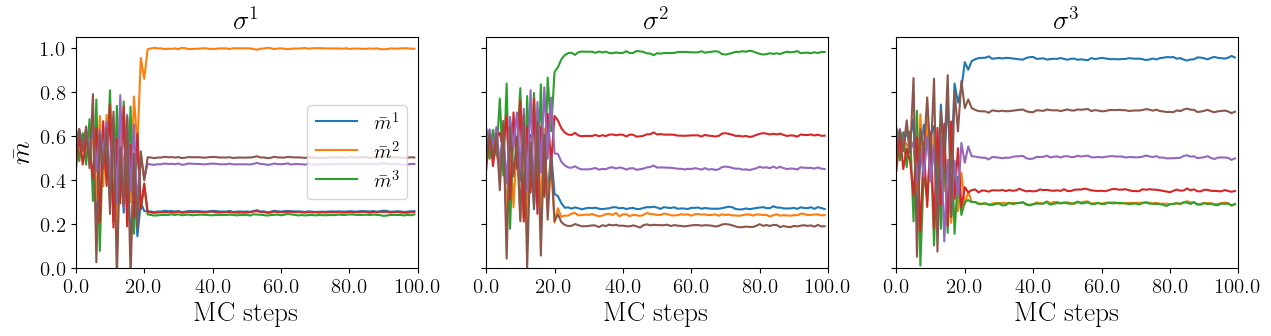

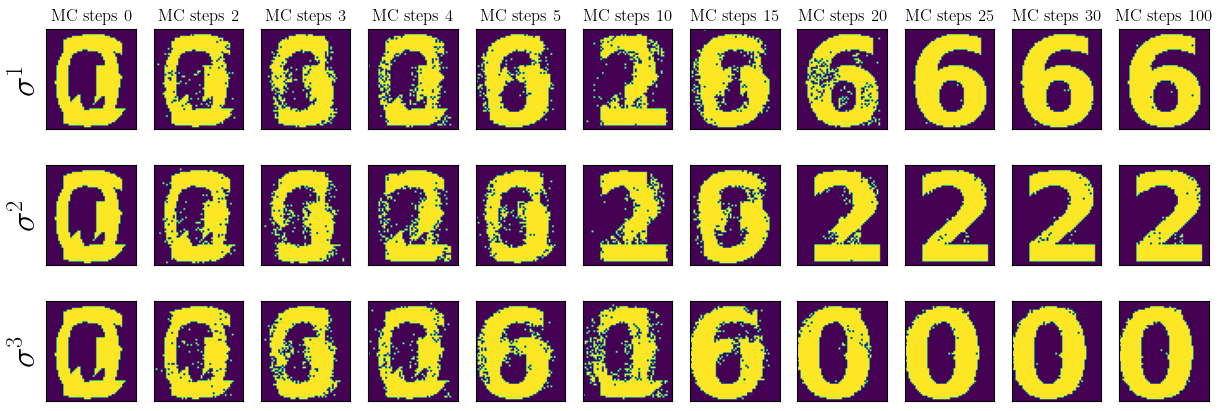

In [14]:
# plot of the magnetizations evolution
pl(xx, steps)

# plot og the images evolution
    # MC sampling steps
index=[0, 2, 3, 4, 5, 10, 15, 20, 25, 30, steps]
fig, axes = plt.subplots(3, len(index), figsize=(15, 5))
for i in range(len(index)):
    if i == 0:
        axes[0,i].set_ylabel('$\mathbf{\\sigma}^1$', size = 25, fontweight='bold')
        axes[1,i].set_ylabel('$\mathbf{\\sigma}^2$', size = 25)
        axes[2,i].set_ylabel('$\mathbf{\\sigma}^3$', size = 25)
    axes[0,i].imshow(np.reshape(σ[index[i],:], newshape=ii[0].shape))
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])
    axes[0,i].set_title(f"MC steps {index[i]}")
    axes[1,i].imshow(np.reshape(τ[index[i],:], newshape=ii[0].shape))
    axes[1,i].set_xticks([])
    axes[1,i].set_yticks([])
    axes[2,i].imshow(np.reshape(ϕ[index[i],:], newshape=ii[0].shape))
    axes[2,i].set_xticks([])
    axes[2,i].set_yticks([])
plt.show()